# Extract Climate data from AWRA and clip to vector

Data is on the NCI here: `/g/data/fj8/BoM/AWRA/DATA/CLIMATE/`

Data is on 5 x 5km grid (`crs='EPSG:4326'`). Data is derived through spatial interpolation of station data, which means its good where the station density over Aus is high

To use the `xr_rasterise` function from `dea_tools` you need to clone the repository into a location and add that location to the `sys.path.insert()` line where the libraries are loaded. To clone the repo type `git clone https://github.com/GeoscienceAustralia/dea-notebooks.git` into the command line

Depending on the environment you are using you may also need to install some of the packages commented out below

In [1]:
# !pip install rasterstats
# !pip install odc-geo
# !pip install geopy

In [2]:
import xarray as xr
import geopandas as gpd
from odc.geo.xr import assign_crs

import sys
sys.path.insert(1, '/g/data/os22/chad_tmp/dea-notebooks/Tools')
from dea_tools.spatial import xr_rasterize

## Analysis Parameters

Options for climate variables to load include:

* `'rain_day'` : daily precipitation
* `'solar_exposure_day'` : daily total incoming shortwave radiation
* `'temp_max_day'` : daily maximum temperature
* `'temp_min_day'` : daily minimum temperature
* `'vapour_pressure'` : daily vapour pressure
* `'wind'` : daily wind

In [3]:
#vector file location
shapefile_path = '/g/data/os22/chad_tmp/NEE_modelling/data/Surface Water Water Resource Plan Areas-FG.shp'

# What climate data do you want to load?
climate_variable = 'rain_day'

#start and end year to load
start, end = 1980, 2021

#name and path for netcdf file exported
export_path = '/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/rain_day_MDB_1980_2021.nc'

## Open vector file

In [4]:
gdf = gpd.read_file(shapefile_path)

## Optionally explore the vector file

In [5]:
# gdf.explore()

## Create a mask from the vector file

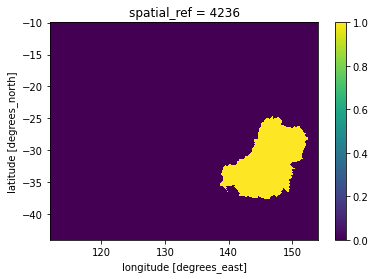

In [6]:
#need to load one file first to use as a template
ds = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/'+climate_variable+'/'+climate_variable+'_2020.nc')
ds = assign_crs(ds, crs='epsg:4236') #make sure it has CRS info
mask = xr_rasterize(gdf, ds) #create mask
mask.plot()

## Load all datasets and concatenate into one large file

This may take a couple of minutes to run depending on the size of the datasets loading

In [7]:
aa = []
i = 0
for y in range(start, end+1):
    print(" {:02}/{:02}\r".format(i + 1, len(range(start, end+1))), end="")
    year = str(y)
    ds = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/'+climate_variable+'/'+climate_variable+'_'+year+'.nc')
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    ds = assign_crs(ds, crs='epsg:4236')
    ds = ds.where(mask, drop=True)
    aa.append(ds)
    i+=1
    
ds = xr.concat(aa, dim='time').sortby('time')

## Export data as a netcdf

In [8]:
ds.to_netcdf(export_path)

## Some plots

### Monthly cumulative rainfall over the whole region

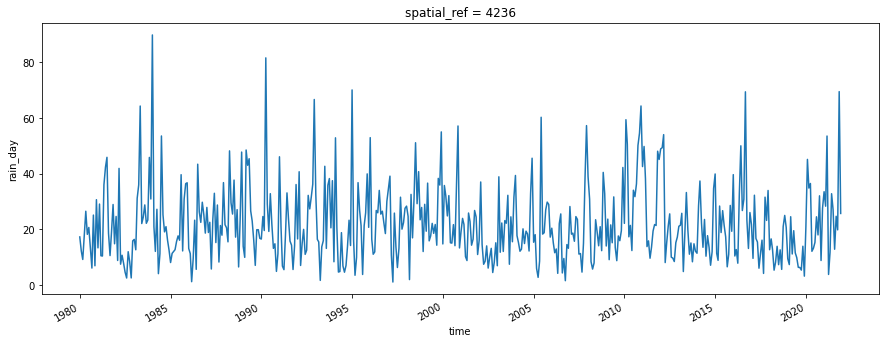

In [9]:
ds[climate_variable].resample(time='MS').sum().mean(['latitude', 'longitude']).plot(figsize=(15,5));

### Facet plot monthly cumulative rainfall for 2011

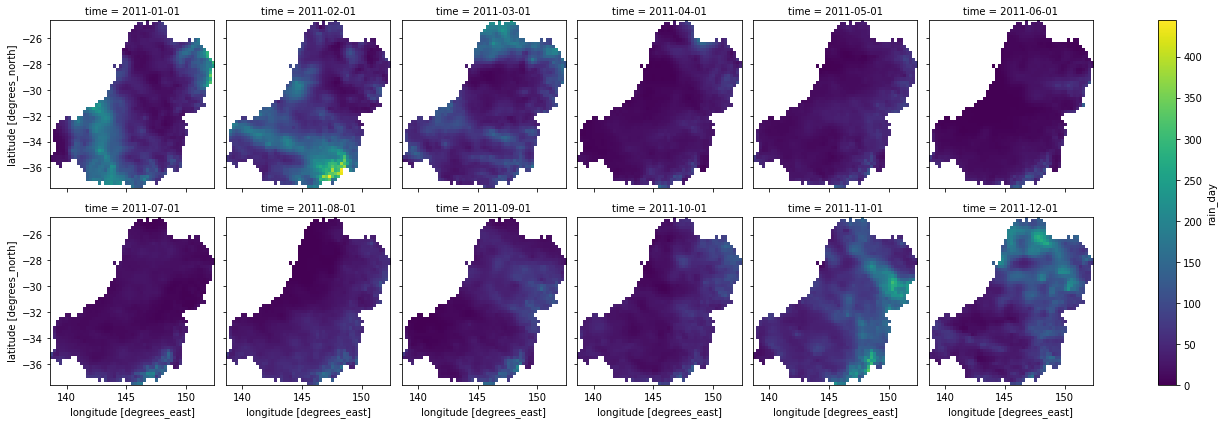

In [10]:
ds[climate_variable].sel(time='2011').resample(time='MS').sum().where(mask).plot.imshow(col='time', col_wrap=6);